In [1]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [24]:
import logging
from pathlib import Path
from typing import Any, Dict, Tuple

import numpy as np
import pandas as pd

# import PIL
import SimpleITK as sitk

# from PIL.Image import Resampling
# from skimage.measure import find_contours
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from tqdm import tqdm

logger = logging.getLogger(__name__)

# Assumes that the database_nifti folder is located under mamba-mic/data/CAMUS
database_nifti_root = Path("../data/CAMUS/database_nifti")

lv_endo_label = 1  # left ventricle endocardium label
lv_epi_label = 2  # left ventricle epicardium label
la_label = 3  # left atrium label

In [3]:
def sitk_load(filepath: str | Path) -> Tuple[np.ndarray, Dict[str, Any]]:
    """Loads an image using SimpleITK and returns the image and its metadata.

    Args:
        filepath: Path to the image.

    Returns:
        - ([N], H, W), Image array.
        - Collection of metadata.
    """
    # Load image and save info
    image = sitk.ReadImage(str(filepath))
    info = {
        "origin": image.GetOrigin(),
        "spacing": image.GetSpacing(),
        "direction": image.GetDirection(),
    }

    # Extract numpy array from the SimpleITK image object
    im_array = np.squeeze(sitk.GetArrayFromImage(image))

    return im_array, info

In [4]:
def load_meta(patient_path, view):
    cfg = {}
    with open(patient_path / f"Info_{view}.cfg", "r") as f:
        for line in f:
            key, value = line.split(": ")
            cfg[key.strip()] = value.strip()
    return cfg

In [5]:
load_meta(database_nifti_root / "patient0001", "2CH")

{'ED': '1',
 'ES': '18',
 'NbFrame': '18',
 'Sex': 'F',
 'Age': '56',
 'ImageQuality': 'Good',
 'EF': '54',
 'FrameRate': '48.4'}

## Load and visualize data

Each patient has 2D images of end diastolic (ED) and end systolic (ES) two chamber (2CH) and four chamber (4CH) views. This is what is used to measure ejection fraction (EF). Each patient also has 2CH and 4CH half sequences with every frame in between ED and ES. The metadata for a given patient and view shows what how many frames there are (NbFrame), the framerate, image quality, ejection fraction, etc.

In [6]:
# Select the patient identification (scalar value between 1 and 500)
patient_id = 1
# Select the view and instant to be loaded

# Specify the ID and path of the patient to be loaded
patient_name = f"patient{patient_id:04d}"
patient_dir = database_nifti_root / patient_name
image_pattern = "{patient_name}_{view}_{instant}.nii.gz"
gt_mask_pattern = "{patient_name}_{view}_{instant}_gt.nii.gz"
print(f"Loading data from patient folder: {patient_dir}")

Loading data from patient folder: ../data/CAMUS/database_nifti/patient0001


a2c_ed_info:  {'origin': (0.0, 0.0), 'spacing': (0.30799999833106995, 0.30799999833106995), 'direction': (1.0, 0.0, 0.0, 1.0)} Shape:  (389, 549)
a2c_es_info:  {'origin': (0.0, 0.0), 'spacing': (0.30799999833106995, 0.30799999833106995), 'direction': (1.0, 0.0, 0.0, 1.0)} Shape:  (389, 549)
a4c_ed_info:  {'origin': (0.0, 0.0), 'spacing': (0.30799999833106995, 0.30799999833106995), 'direction': (1.0, 0.0, 0.0, 1.0)} Shape:  (389, 549)
a4c_es_info:  {'origin': (0.0, 0.0), 'spacing': (0.30799999833106995, 0.30799999833106995), 'direction': (1.0, 0.0, 0.0, 1.0)} Shape:  (389, 549)
Metadata 2CH: {'ED': '1', 'ES': '18', 'NbFrame': '18', 'Sex': 'F', 'Age': '56', 'ImageQuality': 'Good', 'EF': '54', 'FrameRate': '48.4'}
Metadata 4CH: {'ED': '1', 'ES': '20', 'NbFrame': '20', 'Sex': 'F', 'Age': '56', 'ImageQuality': 'Good', 'EF': '54', 'FrameRate': '48.4'}


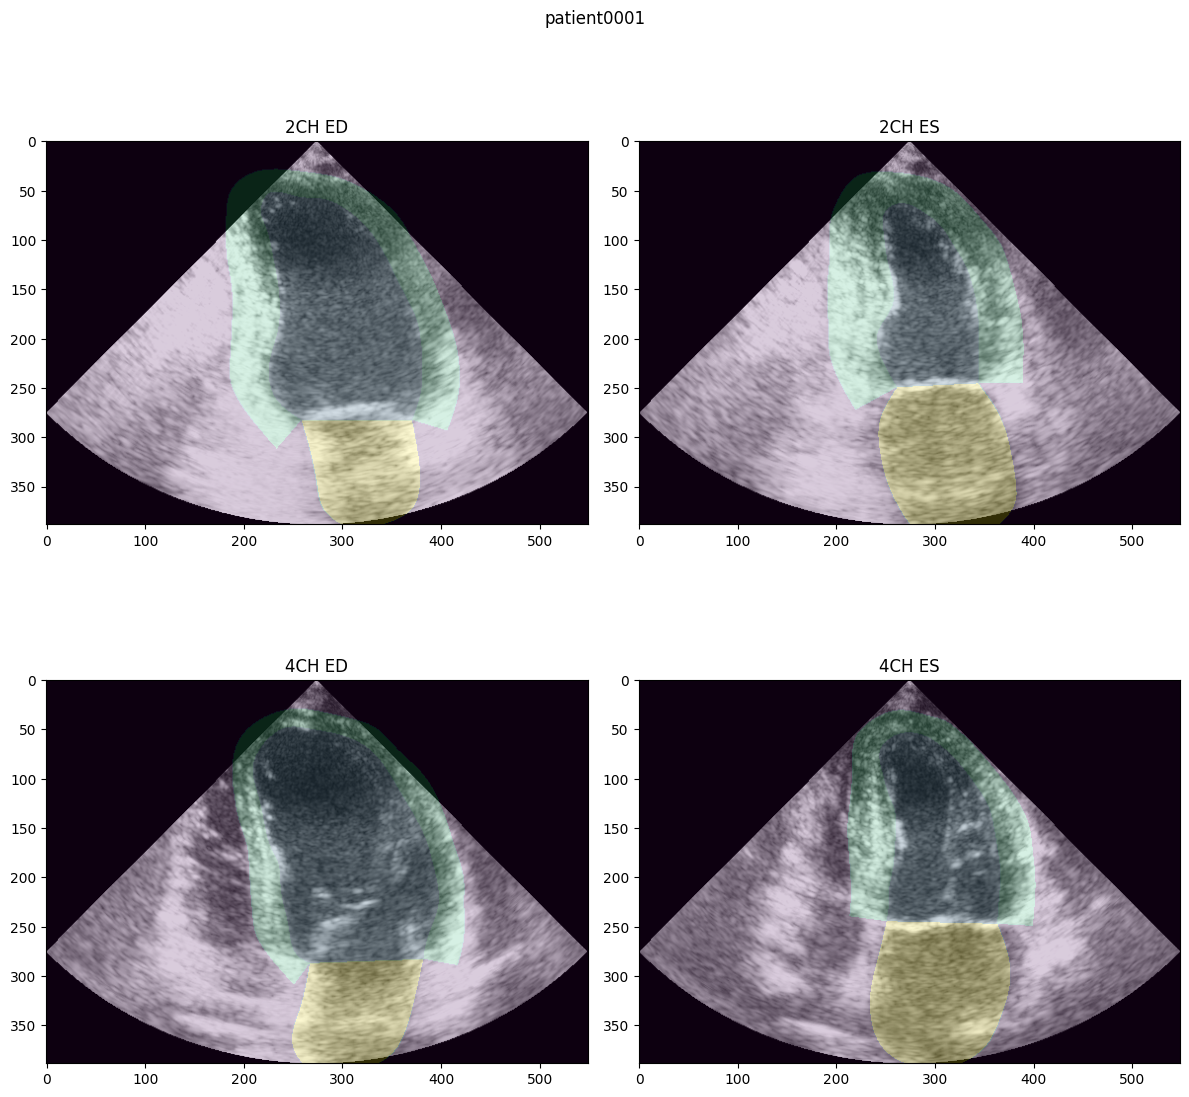

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle(f"{patient_name}")

# 2CH ED
a2c_ed, a2c_ed_info = sitk_load(
    patient_dir
    / image_pattern.format(patient_name=patient_name, view="2CH", instant="ED")
)
a2c_ed_gt, _ = sitk_load(
    patient_dir
    / gt_mask_pattern.format(patient_name=patient_name, view="2CH", instant="ED")
)
print("a2c_ed_info: ", a2c_ed_info, "Shape: ", a2c_ed.shape)
axes[0, 0].set_title("2CH ED")
axes[0, 0].imshow(a2c_ed, cmap="gray")
axes[0, 0].imshow(a2c_ed_gt, alpha=0.2)

# 2CH ES
a2c_es, a2c_es_info = sitk_load(
    patient_dir
    / image_pattern.format(patient_name=patient_name, view="2CH", instant="ES")
)
a2c_es_gt, _ = sitk_load(
    patient_dir
    / gt_mask_pattern.format(patient_name=patient_name, view="2CH", instant="ES")
)
print("a2c_es_info: ", a2c_es_info, "Shape: ", a2c_es.shape)
axes[0, 1].set_title("2CH ES")
axes[0, 1].imshow(a2c_es, cmap="gray")
axes[0, 1].imshow(a2c_es_gt, alpha=0.2)

# 4CH ED
a4c_ed, a4c_ed_info = sitk_load(
    patient_dir
    / image_pattern.format(patient_name=patient_name, view="4CH", instant="ED")
)
a4c_ed_gt, _ = sitk_load(
    patient_dir
    / gt_mask_pattern.format(patient_name=patient_name, view="4CH", instant="ED")
)
print("a4c_ed_info: ", a4c_ed_info, "Shape: ", a4c_ed.shape)
axes[1, 0].set_title("4CH ED")
axes[1, 0].imshow(a4c_ed, cmap="gray")
axes[1, 0].imshow(a4c_ed_gt, alpha=0.2)

# 4CH ES
a4c_es, a4c_es_info = sitk_load(
    patient_dir
    / image_pattern.format(patient_name=patient_name, view="4CH", instant="ES")
)
a4c_es_gt, _ = sitk_load(
    patient_dir
    / gt_mask_pattern.format(patient_name=patient_name, view="4CH", instant="ES")
)
print("a4c_es_info: ", a4c_es_info, "Shape: ", a4c_es.shape)
axes[1, 1].set_title("4CH ES")
axes[1, 1].imshow(a4c_es, cmap="gray")
axes[1, 1].imshow(a4c_es_gt, alpha=0.2)

plt.tight_layout()

print(f"Metadata 2CH: {load_meta(database_nifti_root / patient_name, '2CH')}")
print(f"Metadata 4CH: {load_meta(database_nifti_root / patient_name, '4CH')}")

#### Plot half sequences

In [17]:
def plot_half_sequence(patient_name: str, view: str):
    image_pattern = "{patient_name}_{view}_{instant}.nii.gz"
    gt_mask_pattern = "{patient_name}_{view}_{instant}_gt.nii.gz"

    half_sequence, half_sequence_info = sitk_load(
        patient_dir
        / image_pattern.format(
            patient_name=patient_name, view=view, instant="half_sequence"
        )
    )
    half_sequence_gt, _ = sitk_load(
        patient_dir
        / gt_mask_pattern.format(
            patient_name=patient_name, view=view, instant="half_sequence"
        )
    )
    print(half_sequence_info)
    print("Shape: ", half_sequence.shape)

    def plot_sequences(frame_idx):
        plt.imshow(half_sequence[frame_idx], cmap="gray")
        plt.imshow(half_sequence_gt[frame_idx], alpha=0.2, cmap="jet")
        plt.title(f"{view} View")
        plt.axis("off")
        plt.show()

    # Create slider for frame selection
    interact(
        plot_sequences,
        frame_idx=IntSlider(min=0, max=len(half_sequence) - 1, step=1, value=0),
    )

In [18]:
plot_half_sequence("patient0001", "4CH")

{'origin': (0.0, 0.0, 0.0), 'spacing': (0.30799999833106995, 0.30799999833106995, 1.0), 'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)}
Shape:  (20, 389, 549)


interactive(children=(IntSlider(value=0, description='frame_idx', max=19), Output()), _dom_classes=('widget-in…

## Dataset statistics

In [33]:
stats = {
    "patient_id": [],
    "view": [],
    "spacing": [],
    "shape": [],
    "height": [],
    "width": [],
    "origin": [],
    "direction": [],
    "num_frames": [],
    "ED_frame": [],
    "ES_frame": [],
    "EF": [],
    "frame_rate": [],
    "image_quality": [],
    "sex": [],
    "age": [],
}
for patient_id in tqdm(range(1, 501)):
    patient_name = f"patient{patient_id:04d}"
    patient_dir = database_nifti_root / patient_name
    image_pattern = "{patient_name}_{view}_{instant}.nii.gz"
    gt_mask_pattern = "{patient_name}_{view}_{instant}_gt.nii.gz"
    for view in ["2CH", "4CH"]:
        for instant in ["ES"]:
            image_path = patient_dir / image_pattern.format(
                patient_name=patient_name, view=view, instant=instant
            )
            gt_mask_path = patient_dir / gt_mask_pattern.format(
                patient_name=patient_name, view=view, instant=instant
            )
            if not image_path.exists() or not gt_mask_path.exists():
                logger.warning(f"Patient {patient_name} {view} {instant} not found")
                continue
            image, image_info = sitk_load(image_path)
            gt_mask, _ = sitk_load(gt_mask_path)
            meta = load_meta(patient_dir, view)
            stats["patient_id"].append(patient_id)
            stats["view"].append(view)
            stats["spacing"].append(image_info["spacing"])
            stats["shape"].append(image.shape)
            stats["height"].append(image.shape[0])
            stats["width"].append(image.shape[1])
            stats["origin"].append(image_info["origin"])
            stats["direction"].append(image_info["direction"])
            stats["num_frames"].append(meta["NbFrame"])
            stats["ED_frame"].append(meta["ED"])
            stats["ES_frame"].append(meta["ES"])
            stats["EF"].append(meta["EF"])
            stats["frame_rate"].append(meta["FrameRate"])
            stats["image_quality"].append(meta["ImageQuality"])
            stats["sex"].append(meta["Sex"])
            stats["age"].append(meta["Age"])

stats = pd.DataFrame(stats)

100%|██████████| 500/500 [00:42<00:00, 11.64it/s]


In [39]:
stats.head(10)

,patient_id,view,spacing,shape,height,width,origin,direction,num_frames,ED_frame,ES_frame,EF,frame_rate,image_quality,sex,age
0,1,2CH,"(0.30799999833106995, 0.30799999833106995)","(389, 549)",389,549,"(0.0, 0.0)","(1.0, 0.0, 0.0, 1.0)",18,1,18,54,48.4,Good,F,56
1,1,4CH,"(0.30799999833106995, 0.30799999833106995)","(389, 549)",389,549,"(0.0, 0.0)","(1.0, 0.0, 0.0, 1.0)",20,1,20,54,48.4,Good,F,56
2,2,2CH,"(0.30799999833106995, 0.30799999833106995)","(584, 748)",584,748,"(0.0, 0.0)","(1.0, 0.0, 0.0, 1.0)",17,1,17,40,50.5,Medium,M,55
3,2,4CH,"(0.30799999833106995, 0.30799999833106995)","(584, 748)",584,748,"(0.0, 0.0)","(1.0, 0.0, 0.0, 1.0)",15,1,15,40,50.5,Medium,M,55
4,3,2CH,"(0.30799999833106995, 0.30799999833106995)","(487, 591)",487,591,"(0.0, 0.0)","(1.0, 0.0, 0.0, 1.0)",17,1,17,51,56.5,Good,F,36
5,3,4CH,"(0.30799999833106995, 0.30799999833106995)","(487, 591)",487,591,"(0.0, 0.0)","(1.0, 0.0, 0.0, 1.0)",21,1,21,51,56.5,Good,F,36
6,4,2CH,"(0.30799999833106995, 0.30799999833106995)","(454, 641)",454,641,"(0.0, 0.0)","(1.0, 0.0, 0.0, 1.0)",19,1,19,56,48.4,Good,F,79
7,4,4CH,"(0.30799999833106995, 0.30799999833106995)","(454, 641)",454,641,"(0.0, 0.0)","(1.0, 0.0, 0.0, 1.0)",18,1,18,56,48.4,Medium,F,79
8,5,2CH,"(0.30799999833106995, 0.30799999833106995)","(487, 591)",487,591,"(0.0, 0.0)","(1.0, 0.0, 0.0, 1.0)",20,1,20,46,56.5,Medium,F,78
9,5,4CH,"(0.30799999833106995, 0.30799999833106995)","(487, 591)",487,591,"(0.0, 0.0)","(1.0, 0.0, 0.0, 1.0)",20,1,20,46,56.5,Good,F,78
